# Part I: Generating the Data
The main idea is, we want to predict how much “free cash” a company will generate next year, the year after that, and so on. And because money today is worth more than money tomorrow (that’s why interest rates exist), we *discount* the money in future years before adding the results together.

You can read more on DCF models [here](https://www.investopedia.com/terms/d/dcf.asp) and [here](https://corporatefinanceinstitute.com/resources/knowledge/valuation/dcf-formula-guide/) and [here](https://sba.thehartford.com/finance/cash-flow/discounted-cash-flow/), or type the term into Google and find a million resources (I do recommend!)

For this lesson we’ll create a DCF model using financial data for Apple, maker of iPhones and iPads, and currently the largest company in the stock market (by market cap). To follow along manually, go to [stockrow](https://stockrow.com/) , type “AAPL” into the search bar, and navigate to the “Financials” section — specifically the “trailing” section which is short for Trailing 12 Months.

Download (or “Export”) the .xlsx files for the Income Statement (TTM), Cash Flow statement (TTM), and Balance Sheet (Quarterly)

I had previously downloaded these Excel workbooks to my local machine, and then wrote python code to quickly format the data so that it’s more compatible with the Pandas python library:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pull the income statement, balance sheet, and cash flow statement 
# as downloaded from stockrow.com
aapl_inc_df = pd.read_excel(f'./Income/AAPL_inc.xlsx').T
aapl_bal_df = pd.read_excel(f'./BalanceSheet/AAPL_bal.xlsx').T
aapl_cfl_df = pd.read_excel(f'./CashFlow/AAPL_cashflow.xlsx').T

# change the first row to be the column headers
aapl_inc_df.columns = aapl_inc_df.iloc[0]
aapl_bal_df.columns = aapl_bal_df.iloc[0]
aapl_cfl_df.columns = aapl_cfl_df.iloc[0]

#remove the first row
aapl_inc_df = aapl_inc_df.iloc[1:]
aapl_bal_df = aapl_bal_df.iloc[1:]
aapl_cfl_df = aapl_cfl_df.iloc[1:]

#check out the head, just make sure
aapl_inc_df.head(2)

Unnamed: 0,Revenue,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expenses,Operating Income,Interest Expense (Operating),Non-operating Income/Expense,Non-operating Interest Expenses,EBT,...,Free Cash Flow Margin,EBITDA,EBIT,"EPS (Diluted, from Cont. Ops)","EPS (Basic, Consolidated)","EPS (Basic, from Continuous Ops)",Income from Continuous Operations,Consolidated Net Income/Loss,EBITDA Margin,Operating Cash Flow Margin
2021-03-31 00:00:00,3.25208e+11,1.98607e+11,1.26601e+11,2.0161e+10,2.0712e+10,8.8903e+10,2.639e+09,1e+07,3.134e+09,8.9628e+10,...,0.2782,9.6645e+10,8.8903e+10,4.4649,4.5129,4.5129,7.6311e+10,7.6311e+10,0.2972,0.3062
2020-12-31 00:00:00,2.93971e+11,1.80236e+11,1.13735e+11,1.9464e+10,2.035e+10,7.4253e+10,2.726e+09,-7.46e+08,3.465e+09,7.4752e+10,...,0.2729,8.4827e+10,7.4253e+10,3.7076,3.7474,3.7474,6.393e+10,6.393e+10,0.2886,0.3025


There are very many fields in the original Excel workbooks, only some of which we’re interested in, so let’s:
- Identify those columns / variables we’re interested in
- Extract only those fields
- Combine the 3 DataFrames into 1

In [3]:
# these are the columns we're interested in
inc_columns = ['Revenue','Gross Profit','Operating Income','Income Tax Provision', 'Net Income Common']
bal_columns = ['Total Assets','Total current assets','Total liabilities','Total current liabilities',
               'Shareholders Equity (Total)','Shares (Common)']
cfl_columns = ['Dividends Paid (Common)','Capital expenditures','Operating Cash Flow','Equity Repurchase (Common, Net)']

# this will apply only the columns above to each of our financial statement DataFrames
aapl_inc_df = aapl_inc_df[inc_columns]
aapl_bal_df = aapl_bal_df[bal_columns]
aapl_cfl_df = aapl_cfl_df[cfl_columns]

# this will combine or concatenate our three DataFrames into one
aapl_df = pd.concat([aapl_inc_df,aapl_bal_df,aapl_cfl_df], axis=1)

aapl_df.head(2)

Unnamed: 0,Revenue,Gross Profit,Operating Income,Income Tax Provision,Net Income Common,Total Assets,Total current assets,Total liabilities,Total current liabilities,Shareholders Equity (Total),Shares (Common),Dividends Paid (Common),Capital expenditures,Operating Cash Flow,"Equity Repurchase (Common, Net)"
2021-03-31 00:00:00,3.25208e+11,1.26601e+11,8.8903e+10,1.3317e+10,7.6311e+10,3.37158e+11,1.21465e+11,2.6798e+11,1.06385e+11,6.9178e+10,1.66863e+10,-1.4227e+10,-9.118e+09,9.9591e+10,-7.539e+10
2020-12-31 00:00:00,2.93971e+11,1.13735e+11,7.4253e+10,1.0822e+10,6.393e+10,3.54054e+11,1.54106e+11,2.8783e+11,1.32507e+11,6.6224e+10,1.68233e+10,-1.4155e+10,-8.702e+09,8.8921e+10,-7.5549e+10


I just chose my own preferred set of financial columns, but please explore and see if you'd rather add / subtract others.

To recap: we now have clean DataFrames filled with up to 10 years of relevant financial data for AAPL, indexed on a quarterly basis.

## Part II: Calculating growth
Let’s take a look at Apple’s Revenue over the last 10 years:

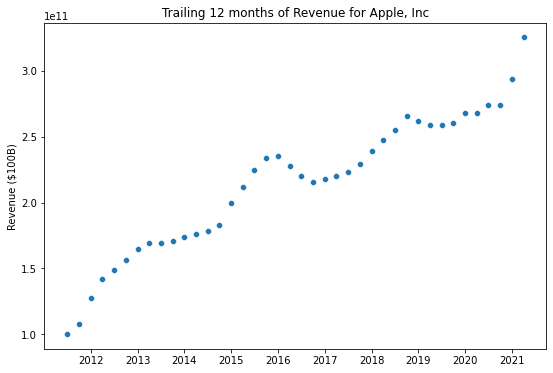

In [4]:
# TTM - Revenue
plt.figure(figsize=(9,6))
sns.scatterplot(x=aapl_df.index,y=aapl_df['Revenue'])
plt.title('Trailing 12 months of Revenue for Apple, Inc')
plt.ylabel('Revenue ($100B)');

Their annual revenues have grown from roughly \\$100B to$300B over the course of a decade. What's the growth rate?

Let's find the most recent one-year change in Revenue with the following code. It's a simple difference formula that indexes 4 quarters apart.

<!--Well, the 1-yr growth rate is different from the 2-yr growth rate and so on.--> 

In [5]:
# 1-year growth rate, last year of the dataset
(aapl_df['Revenue'][0] - aapl_df['Revenue'][4]) / aapl_df['Revenue'][4]


0.21339477268063356

Extending the formula to 2 years, we follow this algorithm:
- Find the percent difference over the last 8 quarters (t0 minus t8)
- Add 1
- Find tyr1_growth*n*th root (raise power to the (1/**2**) for n = **2** years)
- Subtract 1


In [6]:
# 2-year growth rate, last year of the dataset
(1 + (aapl_df['Revenue'][0] - aapl_df['Revenue'][8]) / aapl_df['Revenue'][8])**(1/2)-1

0.12165355461657912

There's another method we can use to calculate average growth over the last 10 years. Namely, we iterate through every quarter in the dataset and capture its 1-yr growth rate.

Create a list comprehension to capture each iterated growth rate, then sum all entries and divide by number of entries

In [7]:
# averaging all 1-yr revenue growths
rev_growth_list = [((aapl_df['Revenue'][i] - aapl_df['Revenue'][i+4]) / aapl_df['Revenue'][i+4]) 
                   for i in range(0,len(aapl_df['Revenue'])-4)]

sum(rev_growth_list)/len(rev_growth_list)

0.11133725497985407

## What about other growth rates?

Let's look at some other metrics:

In [8]:
#calculating all average growths at once
growth_list = []
for col in aapl_df.columns:
    try:
        col_growth_list = [((aapl_df[col][i] - aapl_df[col][i+4]) / aapl_df[col][i+4]) 
                           for i in range(0,len(aapl_df[col])-4)]
        print(f"Avg growth for {col} is {sum(col_growth_list)/len(col_growth_list)}")
        growth_list.append(sum(col_growth_list)/len(col_growth_list))
    except:
        print(f"{col} throws an error")

print(f"Avg growth: {sum(growth_list)/len(growth_list)}")

Avg growth for Revenue is 0.11133725497985407
Avg growth for Gross Profit is 0.10594369552209343
Avg growth for Operating Income is 0.08996071324022206
Avg growth for Income Tax Provision is 0.041693283427884045
Avg growth for Net Income Common is 0.1034889307872158
Avg growth for Total Assets is 0.1229159743282768
Avg growth for Total current assets is 0.13270611753933415
Avg growth for Total liabilities is 0.23556981918745235
Avg growth for Total current liabilities is 0.1623257958285469
Avg growth for Shareholders Equity (Total) is -0.003583780903502146
Avg growth for Shares (Common) is -0.046694381827137886
Dividends Paid (Common) throws an error
Avg growth for Capital expenditures is 0.12999951725249131
Avg growth for Operating Cash Flow is 0.1006475188816269
Avg growth for Equity Repurchase (Common, Net) is -0.32919617910389176
Avg growth: 0.06836530565289042


##### Sidenote
Based on personal judgment, I’m comfortable removing the lowest values and also the highest values to get a better sense for the ‘typical’ growth rates of AAPL financial metrics:

In [9]:
# this code sorts the growth rates from low to high, 
# then it removes the top 2 and lowest 2
growth_list.sort()
normalized_aapl_growth = sum(growth_list[2:-2]) / len(growth_list[2:-2])
normalized_aapl_growth

0.09351092250554965

## Part III: Discounted Cash Flow analysis
Now that we have a better sense for what we mean by growth rates, let’s use this to predict a ‘true value’ for Apple, Inc.

We’ll start by creating a new metric, one that doesn’t appear on most balance sheets, called Free Cash Flow (FCF). There are many definitions for FCF, but for expediency we’ll use:

**Operating Cash Flow** minus **Capital Expenditures** equals **FCF**

We create a new DataFrame column for FCF:

In [10]:
# defining a new column for FCF
aapl_df['FreeCashFlow'] = aapl_df['Operating Cash Flow'] - aapl_df['Capital expenditures']

Using our list comprehension method above, we can determine the average growth rate of FCF over the last decade:

In [11]:
# averaging all FCF growth rates
fcf_growth_list = [((aapl_df['FreeCashFlow'][i] - aapl_df['FreeCashFlow'][i+4]) / aapl_df['FreeCashFlow'][i+4]) 
                   for i in range(0,len(aapl_df['FreeCashFlow'])-4)]

fcf_growth_rate1 = sum(fcf_growth_list)/len(fcf_growth_list)
print(f"Free Cash Flow average 1-yr growth rate: {round(fcf_growth_rate1*100,2)}%")

Free Cash Flow average 1-yr growth rate: 10.03%


The following code projects what next year’s Free Cash Flow might look like, in a series of steps:
- Most recent FCF ($108.7 B)
- Take the most recent FCF and increase by 10.03% (the avg. FCF growth rate)
- Take the above and *decrease* it by the discount rate 1.63%

I chose a discount rate of 1.63\% because it’s equal to the current interest rates on 10-year Treasury Bills. This is purely for expediency; you might use weighted-average cost of capital (WACC) or some other discount rate methodology. Here’s the code:

In [12]:
# Calculate most recent FCF, next year FCF, and discount next year's FCF
bill = 1_000_000_000
discount_rate = 0.0163

print(f"Most recent FCF: ${round(aapl_df['FreeCashFlow'][0]/bill,2)} billion")
print(f"Next year FCF: ${round(aapl_df['FreeCashFlow'][0]*(1+fcf_growth_rate1)/bill,2)} billion")
print(f"Next year FCF, discounted: ${round(aapl_df['FreeCashFlow'][0]*(1+fcf_growth_rate1)**(1)/(1+discount_rate)/bill,2)} billion")

Most recent FCF: $108.71 billion
Next year FCF: $119.62 billion
Next year FCF, discounted: $117.7 billion


Now that we know how to project next year’s discounted FCF, we can naturally extend the analysis to year 2, year 3, and so on. Let’s assume the growth rates for AAPL’s next 10 years will be similar to the last 10. We’ll calculate FCF for each year, then add them all together:

In [13]:
# DCF using the treasury rate as the discount rate and avg. FCF growth as growth rate
treasury_rate = 0.0163
# we start at zero, then incrementally add each subsequent year's FCF
fcf_over_time1 = 0
# our base will be the most recent year's FCF
fcf_start = aapl_df['FreeCashFlow'][0]

# covering a range of 10 years
for i in range(1,10+1):
    fcf_over_time1 += fcf_start * (1+fcf_growth_rate1)**i / (1+treasury_rate)**i
    print(f"Year {i}: ${round(fcf_start * (1+fcf_growth_rate1)**i / (1+treasury_rate)**i / 1_000_000_000,1)} billion")

print(f"Total FCF: ${round(fcf_over_time1/1_000_000_000,1)} billion")

Year 1: $117.7 billion
Year 2: $127.4 billion
Year 3: $138.0 billion
Year 4: $149.4 billion
Year 5: $161.7 billion
Year 6: $175.1 billion
Year 7: $189.6 billion
Year 8: $205.3 billion
Year 9: $222.2 billion
Year 10: $240.6 billion
Total FCF: $1726.9 billion


$1.7 trillion, wow! What about 15 years? Let’s try it! 

Let’s also increase our discount rate to 5%, which will reduce the final value — and that makes sense because it’s so very difficult to project 15 years ahead of time:

In [14]:
# DCF using 5% as the discount rate and avg. FCF growth as growth rate
discount_rate = 0.05
# we start at zero, then incrementally add each subsequent year's FCF
fcf_over_time = 0
# our base will be the most recent year's FCF
fcf_start = aapl_df['FreeCashFlow'][0]

# covering a range of 15 years
for i in range(1,15+1):
    fcf_over_time += fcf_start * (1+fcf_growth_rate1)**i / (1+discount_rate)**i
    print(f"Year {i}: ${round(fcf_start * (1+fcf_growth_rate1)**i / (1+discount_rate)**i / 1_000_000_000,1)} billion")

print(f"Total FCF: ${round(fcf_over_time/1_000_000_000,1)} billion")

Year 1: $113.9 billion
Year 2: $119.4 billion
Year 3: $125.1 billion
Year 4: $131.1 billion
Year 5: $137.4 billion
Year 6: $144.0 billion
Year 7: $150.9 billion
Year 8: $158.1 billion
Year 9: $165.7 billion
Year 10: $173.6 billion
Year 11: $181.9 billion
Year 12: $190.7 billion
Year 13: $199.8 billion
Year 14: $209.4 billion
Year 15: $219.4 billion
Total FCF: $2420.4 billion


##### $2.4 trillion!
How much FCF per share of AAPL common stock?

In [15]:
# turning FCF into per-share stock price predictions
aapl_fcf1 = round(fcf_over_time1/aapl_df['Shares (Common)'][0],2)
aapl_fcf2 = round(fcf_over_time/aapl_df['Shares (Common)'][0],2)

avg_fcf = round((aapl_fcf1 + aapl_fcf2)/2,2)

print(f"Total FCF per share, v1: ${aapl_fcf1}")
print(f"Total FCF per share, v2: ${aapl_fcf2}")
print(f"Average FCF per share: ${avg_fcf}")

Total FCF per share, v1: $103.49
Total FCF per share, v2: $145.05
Average FCF per share: $124.27
